In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import itertools
import matplotlib.pyplot as plt
import statistics as stats
import csv
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

# Functions

In [2]:
def dist(x):
    return(((x[0][0] - x[1][0]) ** 2 + (x[0][1] - x[1][1]) ** 2) ** 0.5)    

# Background Estimation

In [3]:
filename = "videos/video1.avi"
location = "//storage.ncbs.res.in/harshavardanbn/data/210420/F1/"
length = 10000
count = 0
random = np.random.randint(0, length, 50)
k = 5 #kernel size for blurring

bg_frames = [] #stores frames to used for bg calculation

cap = cv2.VideoCapture(location + filename)

if not cap.isOpened:
    print("Cannot open video")

while cap.isOpened:
    
    ret,frame = cap.read()
    
    if ret == 0:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.medianBlur(frame, k)
    
    if count == length:
        break
        
    if count in random:
        copy = frame.copy()
        bg_frames.append(copy)
    
    cv2.imshow("frame", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    count += 1
    
cap.release()
cv2.destroyAllWindows()

bg_frames = np.array(bg_frames)
bg = np.median(bg_frames, axis = 0)
cv2.imshow('Background', cv2.convertScaleAbs(bg))
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Number of frames used for background calculation = ", len(bg_frames))

Number of frames used for background calculation =  6


# Draw circular ROI

In [55]:
mask = np.zeros(bg.shape, dtype=np.uint8)
cv2.circle(mask, (560, 530), radius = 505, color = 255, thickness = -1)
# Apply mask (using bitwise & operator)
cropped = cv2.convertScaleAbs(bg) & mask
cv2.imshow("ROI selected", cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Find size of eyes and swim bladder

In [60]:
filename = "videos/video1.avi"
cap = cv2.VideoCapture(location + filename)
t = 60 #threshold value
while cap.isOpened:

    #load the frame
    ret,frame = cap.read()
    
    #check if frame has been loaded, break otherwise
    if ret == 0:
        break
    
    #convert pixels from (x, x, x) to (x) format
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #find forground 
    fg = cv2.medianBlur(frame, k) - bg
        
    #rescale the foreground
    fg = cv2.convertScaleAbs(fg)
    fg = fg & mask
    
    #binary threshold, fish in white and bg in black
    _, thresh = cv2.threshold(fg, t, 255, cv2.THRESH_BINARY)
    
    #find largest contour which must be the fish, adjust threshold value otherwise
    _, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    areas = []
    for i in contours:
        areas.append(cv2.contourArea(i))
        
    centroids = []
    for i in contours:
        M = cv2.moments(i)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append([cX, cY])
        
    distances = []
    combinations = list(itertools.combinations(centroids, 2))
    for i in combinations:
        distances.append(dist(i))
        
    if len(areas) == 3:
        cv2.imshow("Blobs", thresh[centroids[0][1] - 50: centroids[0][1] + 50, 
                                   centroids[0][0] - 50: centroids[0][0] + 50])                
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
        
print("Areas of detected blobs = ", areas) #[swim_bladder, eye1, eye2]
print("Distances = ", distances) #[swim_bladder -> eye1, swim_bladder -> eye2, eye1 -> eye2]
cap.release()
cv2.destroyAllWindows()

Areas of detected blobs =  [82.5, 31.0, 23.5]
Distances =  [21.37755832643195, 20.615528128088304, 10.295630140987]


# Coordinate extraction

In [61]:
percentage_poor = []
blobs = [max(areas), min(areas)] # approximate size of [eye, swim bladder]
distances = [max(distances), min(distances)] # approx distance between [swim_bladder -> eye, eye1 -> eye2]
for i in range(1, 101):
    filename = "videos/video" + str(i) + ".avi"
    cap = cv2.VideoCapture(location + filename)
    count = 0 # tracks number of frames 
    poor = 0 # tracks number of poorly tracked frames
    poorly_tracked = [] # stores frame numbers of poorly tracked frames
    x = [] # stores x coordinates of centroid of head
    y = [] # stores y coordinates of centroid of head

    while cap.isOpened:
        count += 1

        #load the frame
        ret,frame = cap.read()
    
        #check if frame has been loaded, break otherwise
        if ret == 0:
            break
    
        #convert images from (x, x, x) to (x) format
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
        #find forground 
        fg = cv2.medianBlur(frame, k) - bg
        
        #rescale the foreground
        fg = cv2.convertScaleAbs(fg)
        fg = fg & mask
    
        #binary threshold, fish in white and bg in black
        _, thresh = cv2.threshold(fg, 15, 255, cv2.THRESH_BINARY)
    
        #find largest contour which must be the fish, adjust threshold value otherwise
        _, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        #check if there are any contours in the image        
        if len(contours) == 0:
            poor += 1
            poorly_tracked.append(count - 1)
            continue
    
        #find largest contour
        largest = max(contours, key = cv2.contourArea)
        
        #find centroid of the largest contour
        M = cv2.moments(largest)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
        #set all other contours to 0 in fg
        if len(contours) > 1:
            contours.sort(key = cv2.contourArea, reverse = True)
            contours = contours[1:]
            cv2.fillPoly(fg, contours, 0)            
        
        #crop and roi around the centroid
        roi = fg[cY - 50: cY + 50, cX - 50: cX + 50]
        
        #tracking algorithm
        tracked = False # has this frame been tracked well? Default is False
        for j in range(0, 255, 1):
            areas = []
            areas_sorted = []
            contours_sorted = []
            _, roi_thresh = cv2.threshold(roi, j, 255, cv2.THRESH_BINARY)
            _, contours, _ = cv2.findContours(roi_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            if len(contours) >= 3:
                for l in contours:
                    areas.append(cv2.contourArea(l))
                while len(contours_sorted) < 3:
                    areas_sorted.append(max(areas))
                    contours_sorted.append(contours[areas.index(max(areas))])
                    areas[areas.index(max(areas))] = -1
            else:
                continue
            if (areas_sorted[0] >= 0.5 * blobs[0]) & (areas_sorted[0] <= 1.5 * blobs[0]):
                if (areas_sorted[1] >= 0.5 * blobs[1]) & (areas_sorted[1] <= 1.5 * blobs[1]):
                    if (areas_sorted[2] >= 0.5 * blobs[1]) & (areas_sorted[2] <= 1.5 * blobs[1]):
                        tracked = True # setting tracked to True if all 3 conditions are met
                        break        
        
        if tracked:
            centroids = []
            for b in contours_sorted:
                M = cv2.moments(b)
                centroids.append((int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])))
                rescaled_x = centroids[-1][0] + cX - 50
                rescaled_y = centroids[-1][1] + cY - 50
                centroids[-1] = (rescaled_x, rescaled_y)
                cv2.circle(frame, centroids[-1], 1, 255, -1)
            
            temp_x, temp_y = 0, 0
            for j in centroids:
                temp_x += j[0]
                temp_y += j[1]
            x.append(int(temp_x / 3))
            y.append(int(temp_y / 3))
            
            # draw centroid of triangle
            cv2.circle(frame, (x[-1], y[-1]), 2, 255, -1)
            cv2.imshow("video " + str(i), frame)
            
        else:
            x.append(float("NaN"))
            y.append(float("NaN"))
            poor += 1
            poorly_tracked.append(count - 1)
            cv2.imshow("video " + str(i), frame)
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        if count >= 650:
            break
        
    
    percentage_poor.append(poor / count * 100)
    print("video ", i, ":", percentage_poor[-1], "% frames tracked poorly")
    print("poor = ", poor)
    
    
    #write coordinates into csv file    
    output = [x, y]
    fields = ["x","y"]
    with open(location + "coordinates/coordinates" + str(i) + ".csv", "w") as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow(fields)
        for i in range(len(output[0])):
            csvwriter.writerow([output[0][i], output[1][i]])
    
    with open(location + "coordinates/poorly_tracked" + str(i) + ".csv", "w") as csv_file:
        csvwriter = csv.writer(csv_file)
        for i in poorly_tracked:
            csvwriter.writerow([i])
    
    cap.release()
    cv2.destroyAllWindows()

video  1 : 2.1538461538461537 % frames tracked poorly
poor =  14
video  2 : 0.3076923076923077 % frames tracked poorly
poor =  2
video  3 : 0.3076923076923077 % frames tracked poorly
poor =  2
video  4 : 0.0 % frames tracked poorly
poor =  0
video  5 : 0.0 % frames tracked poorly
poor =  0
video  6 : 0.46153846153846156 % frames tracked poorly
poor =  3
video  7 : 2.0 % frames tracked poorly
poor =  13
video  8 : 1.3846153846153846 % frames tracked poorly
poor =  9
video  9 : 0.3076923076923077 % frames tracked poorly
poor =  2
video  10 : 0.3076923076923077 % frames tracked poorly
poor =  2
video  11 : 0.0 % frames tracked poorly
poor =  0
video  12 : 1.2307692307692308 % frames tracked poorly
poor =  8
video  13 : 1.3846153846153846 % frames tracked poorly
poor =  9
video  14 : 2.6153846153846154 % frames tracked poorly
poor =  17
video  15 : 0.0 % frames tracked poorly
poor =  0
video  16 : 27.384615384615387 % frames tracked poorly
poor =  178
video  17 : 0.0 % frames tracked poorl

(array([88.,  5.,  1.,  1.,  4.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  5.56923077, 11.13846154, 16.70769231, 22.27692308,
        27.84615385, 33.41538462, 38.98461538, 44.55384615, 50.12307692,
        55.69230769]),
 <a list of 10 Patch objects>)

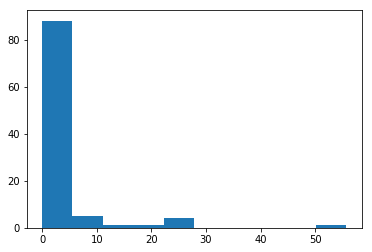

In [62]:
plt.hist(percentage_poor)